In [1]:
import math
import pickle
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import os
import os.path as op
import pandas as pd 

In [ ]:

 
#get_sa_score start
_fscores = None
 
def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    if name == "fpscores":
        name = op.join(os.getcwd(), name)
        # name = op.join(op.dirname(__file__), name)
    data = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro
def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                            2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf
    
    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1
            
    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    # macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)
        
    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty
    
    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5
        
    sascore = score1 + score2 + score3
    
    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
        
    return sascore
def my_score(mols:list):
    readFragmentScores("fpscores")
    import time
    start = time.time()
    print("Starting caclucating...")
#     print('smiles\tsa_score')
    res = []
    for m in mols:
        s = calculateScore(m)
        smiles = Chem.MolToSmiles(m)
#         print(smiles + "\t" + "\t%3f" % s)
        res.append((smiles,s))
    
    df = pd.DataFrame(res)
    df.columns = ['Smiles', 'SA_Score']
    print("Successfully Done!")
    end = time.time()
    running_time = end - start
    print("time cost: %.5f min" % (running_time/60))
    return df
    
if __name__ == "__main__":
#     a = Chem.MolFromSmiles('CN(C)CCC=C1C2=CC=CC=C2CCC2=CC=CC=C12')
#     b = Chem.MolFromSmiles('[H][C@@]12CC3=CNC4=CC=CC(=C34)[C@@]1([H])C[C@H](CN2CC=C)C(=O)N(CCCN(C)C)C(=O)NCC')
#     c = Chem.MolFromSmiles('CCOC1=NC(NC(=O)CC2=CC(OC)=C(Br)C=C2OC)=CC(N)=C1C#N')
#     d = Chem.MolFromSmiles('OC(=O)C1=CC=CC=C1O')
#     x = [a,b,c,d]
#     res = my_score(x)  # 返回smiles与对应的SA_score的DataFrame
    file = pd.read_csv('新模型预测结果-350.csv')
    file.head()
    smiles_list = file['Smiles'].tolist()
    mols = []
    for smile in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smile)
        except BaseException:  # 发现解析错误，就跳过
            pass
        mols.append(mol)
    res = my_score(mols)
    print(res.head())
    res.to_csv('1-350-SAscore.csv') 

In [4]:
file = pd.read_csv('新模型预测结果-350.csv')

df = pd.concat([file,res['SA_Score']],axis=1)
df.shape

(324950, 4)

In [5]:
df.head()

,Unnamed: 0,Smiles,pred_new,SA_Score
0,1,*c1cccc(N2C(=O)c3ccc4c5c(ccc(c35)C2=O)C(=O)N(*...,367.41678,3.419736
1,2,*c1cccc(N2C(=O)c3ccc(C(=O)c4ccc5c(c4)C(=O)N(*)...,350.72488,3.270827
2,3,*c1cccc(N2C(=O)c3ccc4c5ccc6c7c(ccc(c8ccc(c3c48...,365.61154,3.439890
3,6,*c1cccc(N2C(=O)c3cc(Cl)c4c5c(Cl)cc6c7c(cc(Cl)c...,370.96426,3.907398
4,15,*c1cccc(N2C(=O)[C@H]3[C@@H](C2=O)C2(NC(=O)c4cc...,384.54993,5.760158


In [7]:
df = df[['Smiles','pred_new','SA_Score']]
df.head()

,Smiles,pred_new,SA_Score
0,*c1cccc(N2C(=O)c3ccc4c5c(ccc(c35)C2=O)C(=O)N(*...,367.41678,3.419736
1,*c1cccc(N2C(=O)c3ccc(C(=O)c4ccc5c(c4)C(=O)N(*)...,350.72488,3.270827
2,*c1cccc(N2C(=O)c3ccc4c5ccc6c7c(ccc(c8ccc(c3c48...,365.61154,3.439890
3,*c1cccc(N2C(=O)c3cc(Cl)c4c5c(Cl)cc6c7c(cc(Cl)c...,370.96426,3.907398
4,*c1cccc(N2C(=O)[C@H]3[C@@H](C2=O)C2(NC(=O)c4cc...,384.54993,5.760158


# 分布可视化

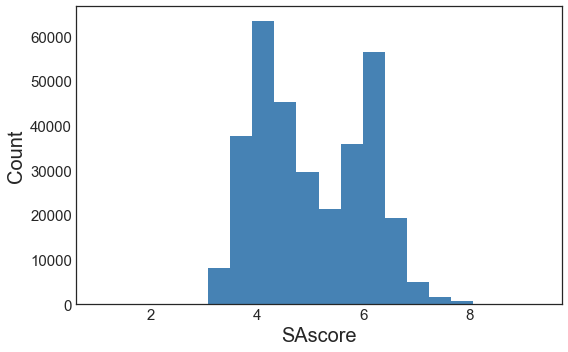

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import pandas as pd 
plt.style.use('seaborn-white')

df = pd.read_csv("1-350-SAscore.csv")
data = df['SA_Score']
#最基本的频次直方图命令
plt.figure(figsize=(8,5))
plt.hist(data,bins=20, histtype='stepfilled',
         color='steelblue', edgecolor='none')
plt.xlabel('SAscore',fontsize =20) 
plt.ylabel('Count',fontsize =20)
plt.tick_params(labelsize=15) 
plt.tight_layout()
plt.savefig('SAscore-distribution.jpg', dpi=1000)
plt.show()

In [10]:
df.describe()

,pred_new,SA_Score
count,324950.000000,324950.000000
mean,377.678630,5.034633
std,25.655026,1.018024
min,350.000030,1.000000
25%,358.922452,4.144913
50%,371.017785,4.829843
75%,389.038705,6.008765
max,557.249270,9.323636


In [12]:
df = df[df['SA_Score']<3]
df.shape

(6, 3)

In [24]:
df= pd.read_csv('预测筛选/1-350-SAscore.csv') 
df.shape

(324950, 4)

In [28]:
df = df[df['SA_Score']<3.2]
df.shape

(89, 4)